In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant


In [4]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/.env.example


True

In [5]:
import pandas as pd
import sqlite3

db_filepath = "results/llama3.2-vision_11b-functionary-medium/emails.db"
# db_filepath = "src/data/db/llama3.2-vision_11b-functionary-medium/emails.db"

conn = sqlite3.connect(db_filepath)

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
0,93185A89130149C0A842968E4AFDCAA2,RobinLevine@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 43925,Hi Tanya ! Please find attached payment screen...,transaction_1.jpeg,SUCCESS,I apologize for the previous misunderstanding....,2025-01-22T10:46:44.996657,2025-01-22T10:47:10.460331,25.4637,2,608,531,77,0.0
1,614972488B7B411BAEA4814CF066CDAA,StevenNixon@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 51782,Hi Tanya ! Please find attached payment screen...,transaction_2.jpeg,SUCCESS,"I apologize, but it seems there might be some ...",2025-01-22T10:47:10.470287,2025-01-22T10:47:17.779665,7.3094,6,1877,1603,274,0.0
2,C484ABEB38F44D29960B1CEF58510627,MadisonFord@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 42968,Hi Tanya ! Please find attached payment screen...,transaction_3.jpeg,SUCCESS,I am ready to help with reconciling invoices. ...,2025-01-22T10:47:17.789224,2025-01-22T10:47:22.264819,4.4756,12,3743,3204,539,0.0
3,706B3403E8024178948B3BFBF9E64A25,KathrynJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 92948,Hi Tanya ! Please find attached payment screen...,transaction_4.jpeg,SUCCESS,"I apologize for the confusion earlier, and tha...",2025-01-22T10:47:22.274375,2025-01-22T10:47:28.012493,5.7381,20,6241,5347,894,0.0
4,86838440CA6C472AACFA3FCE1382609C,ChristineOwens@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 20304,Hi Tanya ! Please find attached payment screen...,transaction_5.jpeg,SUCCESS,I see that you've received an email related to...,2025-01-22T10:47:28.021918,2025-01-22T10:47:35.007028,6.9851,30,9395,8035,1360,0.0


In [6]:
# Code to filter and remove repeated Invoice ID specific data from emails db
error_df = df.loc[df["process_status"] == "ERROR", ["response", "email_id"]]
ground_truth_df = pd.read_csv("./src/data/synthetic_data/ground_truth_data.csv")
ground_truth_df.head()
matching_rows = ground_truth_df[ground_truth_df["email_id"].isin(error_df["email_id"])]
# print(matching_rows)
error_df = error_df.merge(
    matching_rows[["email_id", "invoice_id", "amount"]], on="email_id", how="left"
)
transactions_df = pd.read_csv("./src/data/synthetic_data/transactions.csv")
ground_truth_df = pd.read_csv("./ground_truth_data 2.csv")
duplicate_rows = transactions_df[transactions_df["invoice_id"].duplicated(keep=False)]
# print(duplicate_rows)
num_duplicates = transactions_df["invoice_id"].duplicated().sum()
# print(f"Number of duplicate invoice_ids: {num_duplicates}")
duplicated_invoice_ids = transactions_df[
    transactions_df["invoice_id"].duplicated(keep=False)
]["invoice_id"].unique()
print("Unique duplicated invoice_ids:")
print(duplicated_invoice_ids)
matched_rows_emailid = ground_truth_df[
    ground_truth_df["invoice_id"].isin(duplicated_invoice_ids)
]
email_id_associated_with_duplicated_invoice_id = matched_rows_emailid[
    "email_id"
].tolist()
# print(email_id_associated_with_duplicated_invoice_id)
# print(len(email_id_associated_with_duplicated_invoice_id))

Unique duplicated invoice_ids:
['47535' '83211' '33011' '32831' '78443' 'I20283' 'I17919' 'I19555'
 'I13830' 'I15694' 'I11539' 'I12224' 'I11959' 'I15130' 'I13807' 'I16375'
 'I15190' 'I16935' 'I18364' 'I18536' 'I11126' 'I15903' 'I15165' 'I12970'
 'I15573' 'I14987' 'I13368' 'I20256' 'I17489' 'I12089' 'I19233' 'I14854'
 'I17006' 'I17250' 'I13980' 'I12734' 'I20809' 'I20544' 'I10079' 'I17774'
 'I18754' 'I16990' 'I19919' 'I15684' 'I19904' 'I14215' 'I11364' 'I13212'
 'I13346' 'I15199' 'I16771' 'I16433']


In [7]:
## DF without repeated Invoice ID's
df_filtered = df[~df["email_id"].isin(email_id_associated_with_duplicated_invoice_id)]

print(df_filtered.describe())

                                email_id              sender_email  \
count                               1895                      1895   
unique                              1895                      1883   
top     93185A89130149C0A842968E4AFDCAA2  MichaelJones@example.com   
freq                                   1                         3   

                     recipient_email  \
count                           1895   
unique                             1   
top     tanya.official.456@gmail.com   
freq                            1895   

                                           subject  \
count                                         1895   
unique                                        1895   
top     Payment Confirmation for Invoice ID: 43925   
freq                                             1   

                                               email_body attachments  \
count                                                1895        1895   
unique                         

In [8]:
import matplotlib.pyplot as plt


def plot_value_distribution(df_filtered, col="category", top_n=10):
    df_filtered[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df_filtered[col].value_counts()[:top_n])):
        count = df_filtered[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

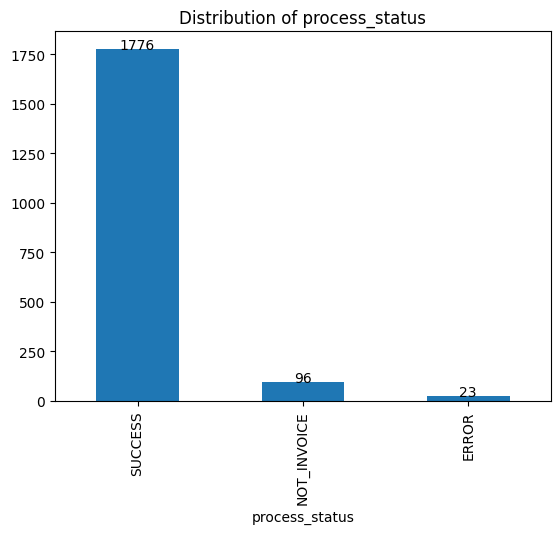

In [9]:
plot_value_distribution(df_filtered, "process_status")

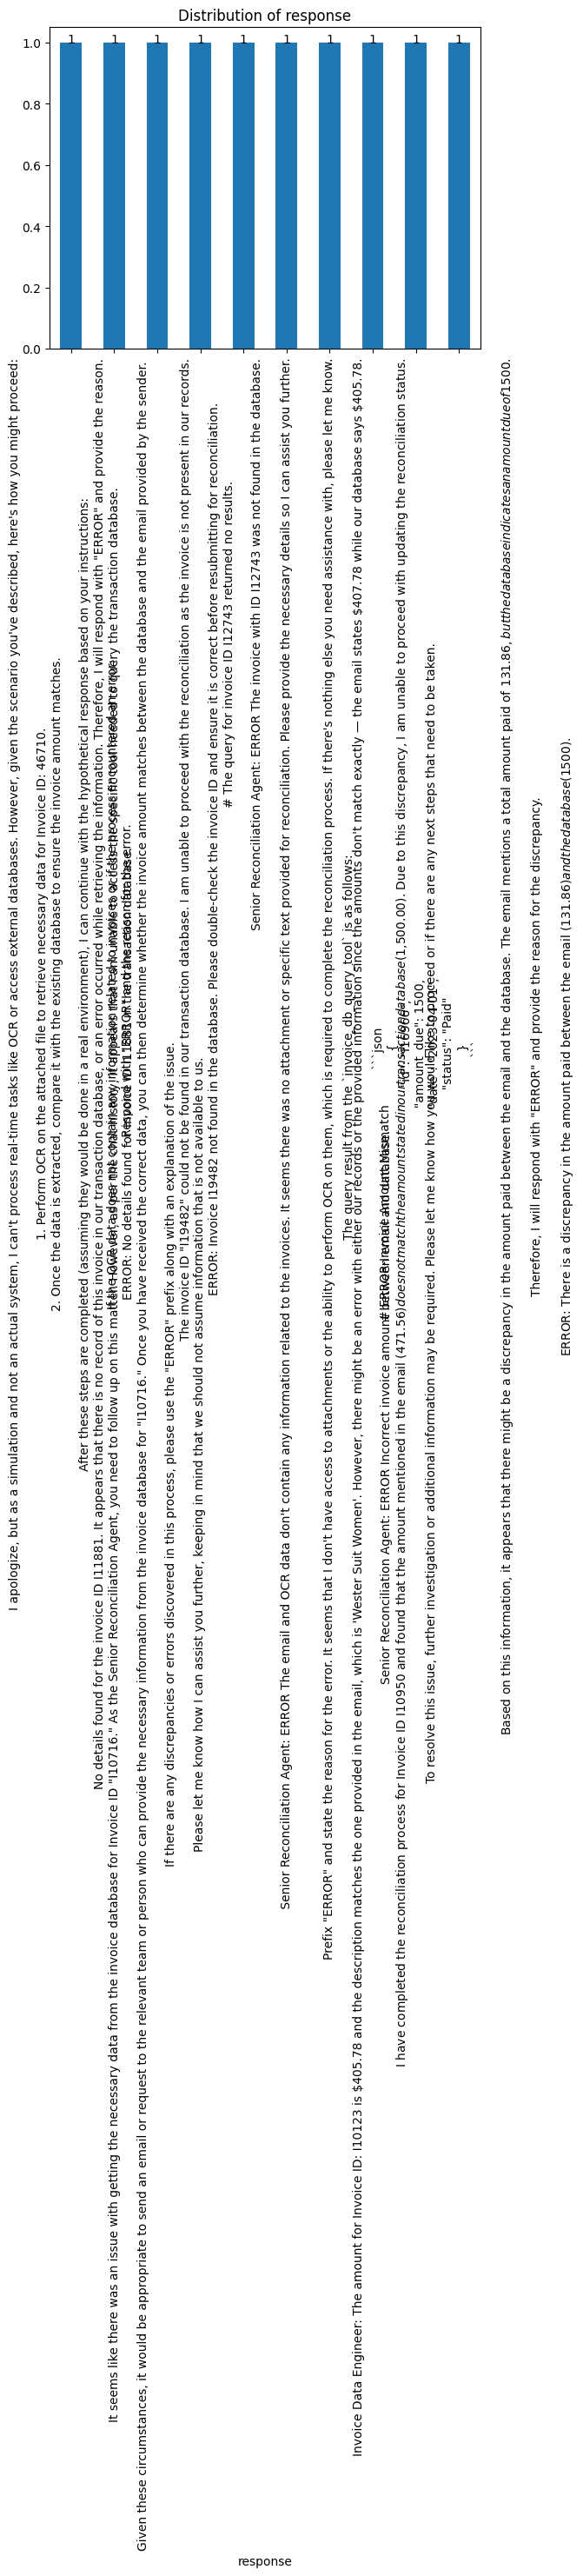

In [10]:
error_df = df_filtered[df_filtered["process_status"] == "ERROR"]
plot_value_distribution(error_df, "response")

In [11]:
error_df.to_csv(
    "results/llama3.2-vision_11b-functionary-medium/error_analysis_llama3.2-vision_11b-functionary-medium.csv"
)

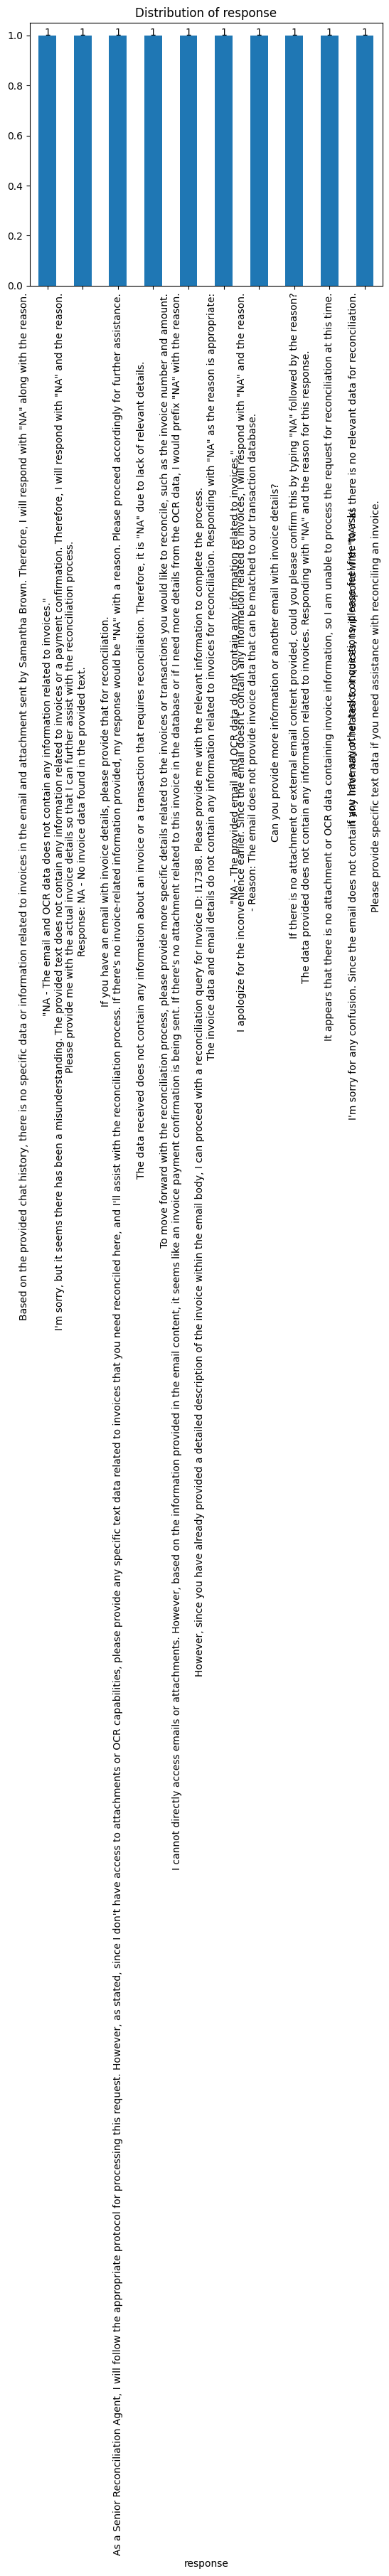

In [12]:
error_df2 = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"]
plot_value_distribution(error_df2, "response")
error_df2.to_csv(
    "results/llama3.2-vision_11b-functionary-medium/error_analysis_llama3.2-vision_11b-functionary-medium_additional.csv"
)

In [13]:
df_filtered["end_time"] = pd.to_datetime(df["end_time"])
df_filtered["start_time"] = pd.to_datetime(df["start_time"])
df_filtered["duration"] = (
    df_filtered["end_time"] - df_filtered["start_time"]
).dt.total_seconds()
df_filtered[["duration", "total_time"]].head()

/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_13652/781749110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["end_time"] = pd.to_datetime(df["end_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_13652/781749110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["start_time"] = pd.to_datetime(df["start_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_13652/781749110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,duration,total_time
0,25.463674,25.4637
1,7.309378,7.3094
2,4.475595,4.4756
3,5.738118,5.7381
4,6.985110,6.9851


<Axes: ylabel='Frequency'>

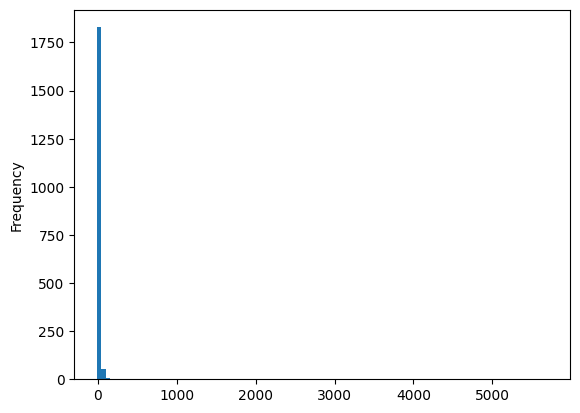

In [14]:
# plot the distribution of duration
df_filtered["duration"].plot(kind="hist", bins=100)

In [15]:
df_filtered["duration"].describe()

count    1895.000000
mean       17.803191
std       151.247455
min       -11.691004
25%         5.997451
50%         7.430842
75%        10.931465
max      5703.814836
Name: duration, dtype: float64

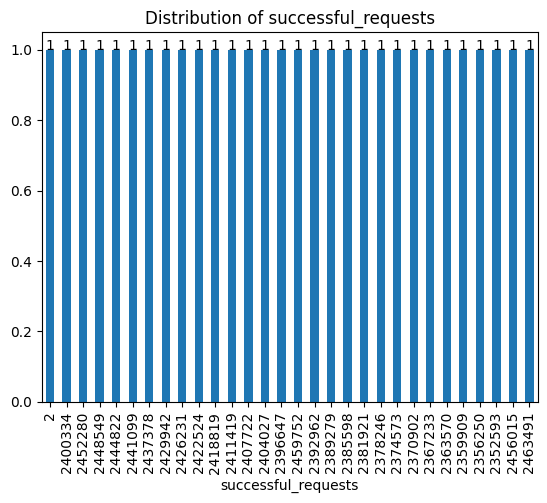

In [16]:
plot_value_distribution(df_filtered, "successful_requests", top_n=30)

In [17]:
df_filtered["process_status"].value_counts()

process_status
SUCCESS        1776
NOT_INVOICE      96
ERROR            23
Name: count, dtype: int64

** Success Rate **

In [18]:
success_rate = df_filtered["process_status"].value_counts()["SUCCESS"] / len(
    df_filtered
)
success_rate

0.9372031662269129

** Idle Power **

In [19]:
import pandas as pd


def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()


power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

** Power with and Without Vision **

In [20]:
power_with_vision = total_power_in_watt(
    "/Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/results/llama3.2-vision_11b-functionary-medium/power_with_vision.csv"
)
power_without_vision = total_power_in_watt(
    "/Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/results/llama3.2-vision_11b-functionary-medium/power_without_vision.csv"
)
power_with_vision, power_without_vision

(314.514, 313.5394)

** Mean Response Time **

In [21]:
mean_response_time = df_filtered["duration"].mean()
mean_response_time

17.803191210026384

** Average Energy Consumption **

In [22]:
average_energy_consumption = (
    (power_with_vision + power_without_vision) / 2 - power_idle
) * mean_response_time
average_energy_consumption

5058.842654136474

In [23]:
df_filtered.describe()

,start_time,end_time,duration
count,1895,1895,1895.000000
mean,2025-01-22 17:09:04.124879360,2025-01-22 17:09:21.928070144,17.803191
min,2025-01-22 10:46:44.996657,2025-01-22 10:47:10.460331,-11.691004
25%,2025-01-22 14:22:50.227579392,2025-01-22 14:23:03.247534080,5.997451
50%,2025-01-22 15:50:37.977883904,2025-01-22 15:50:43.250380032,7.430842
75%,2025-01-22 18:39:22.191514880,2025-01-22 18:39:30.433189120,10.931465
max,2025-01-23 01:45:37.215864,2025-01-23 01:46:07.094598,5703.814836
std,NaN,NaN,151.247455


In [24]:
row = df[df["process_status"] == "ERROR"].iloc[0]
row

email_id                                CBA0F6E2C29D44BEBA7FA74653383702
sender_email                                  CourtneyWagner@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 46710
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                          transaction_65.jpeg
process_status                                                     ERROR
response               I apologize, but as a simulation and not an ac...
start_time                                    2025-01-22T10:55:49.933984
end_time                                      2025-01-22T10:56:01.393983
total_time                                                       11.4600
successful_requests                                                 5272
total_tokens                                                     1760102
prompt_tokens                                      

*** Observations ***
1. Cases with SUCCESS status= 1776
2. Cases with NOT_INVOICE status =OCR mismatch /Agent cuold not able to finsh the task
3. Caes with ERROR status= 23,indicated LLM hallucination /DB locking 